In [4]:
#%pip install auto-sklearn

In [5]:
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name='arcene', version=1)
print(dataset.data.shape)

(200, 10000)


In [6]:
import experimentize as E
from autosklearn.classification import AutoSklearnClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
from sklearn import metrics
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

class Params(E.ParamsBase):
    time_limit = 30
    method = "none"
    max_features = 1000
    seed = 1


@E.experimentize(Params)
class Experiment:
    def feature_selection_none(self, train_x, train_y, *, max_features=E.param):
        return lambda x: x
    
    def feature_selection_random_forest(self, train_x, train_y, *, max_features=E.param, seed=E.param):
        clf = RandomForestClassifier(n_estimators=100, random_state=seed)
        clf.fit(train_x, train_y)
        selector = SelectFromModel(clf, prefit=True, max_features=max_features)
        return lambda x: selector.transform(x)

    def feature_selection_anova(self, train_x, train_y, *, max_features=E.param):
        selector = SelectKBest(f_classif, k=max_features)
        selector.fit(train_x, train_y)
        return lambda x: selector.transform(x)

    def feature_selection_mutual_info(self, train_x, train_y, *, max_features=E.param):
        selector = SelectKBest(mutual_info_classif, k=max_features)
        selector.fit(train_x, train_y)
        return lambda x: selector.transform(x)


    def auto_classifier(self, *, time_limit=E.param, seed=E.param):
        return AutoSklearnClassifier(
            time_left_for_this_task=time_limit,
            include = {
                'feature_preprocessor': ["no_preprocessing"]
            },
            seed=seed
        )
    
    def make_data(self, *, seed=E.param):
        return train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=seed)
    
    def run(self, *, method=E.param(as_func="feature_selection_{}")):
        train_x, test_x, train_y, test_y = self.make_data()
        selector = method(train_x, train_y)
        train_x, test_x = selector(train_x), selector(test_x)

        automl = self.auto_classifier()
        automl.fit(train_x, train_y)
        return {
            "Accuracy (test)": metrics.accuracy_score(test_y, automl.predict(test_x)),
            "Accuracy (train)": metrics.accuracy_score(train_y, automl.predict(train_x)),
            "Features": train_x.shape[1]
        }


In [8]:
grid = [
    Params(method=method, max_features=max_features, seed=seed)
    for method in ["ANOVA", "Mutual Info","Random Forest"]
    for max_features in [500, 200, 75]
    for seed in range(1)
] + [Params(method="None", seed=seed) for seed in range(1)]
results = Experiment().run(E.AsExperiment(grid))()

[WARNING] [2023-05-27 12:24:41,642:Client-AutoMLSMBO(0)::b0d7ca8b-fc78-11ed-b4c4-c7fab43069cd] Configuration 393 not found
[WARNING] [2023-05-27 12:24:41,642:Client-AutoMLSMBO(0)::b0d7ca8b-fc78-11ed-b4c4-c7fab43069cd] Configuration 32 not found
[WARNING] [2023-05-27 12:24:41,642:Client-AutoMLSMBO(0)::b0d7ca8b-fc78-11ed-b4c4-c7fab43069cd] Configuration 546 not found
[WARNING] [2023-05-27 12:24:41,642:Client-AutoMLSMBO(0)::b0d7ca8b-fc78-11ed-b4c4-c7fab43069cd] Configuration 81 not found
[WARNING] [2023-05-27 12:24:41,642:Client-AutoMLSMBO(0)::b0d7ca8b-fc78-11ed-b4c4-c7fab43069cd] Configuration 9 not found
[WARNING] [2023-05-27 12:24:41,642:Client-AutoMLSMBO(0)::b0d7ca8b-fc78-11ed-b4c4-c7fab43069cd] Configuration 440 not found
[WARNING] [2023-05-27 12:24:41,642:Client-AutoMLSMBO(0)::b0d7ca8b-fc78-11ed-b4c4-c7fab43069cd] Configuration 476 not found
[WARNING] [2023-05-27 12:24:41,642:Client-AutoMLSMBO(0)::b0d7ca8b-fc78-11ed-b4c4-c7fab43069cd] Configuration 184 not found
[WARNING] [2023-05-2

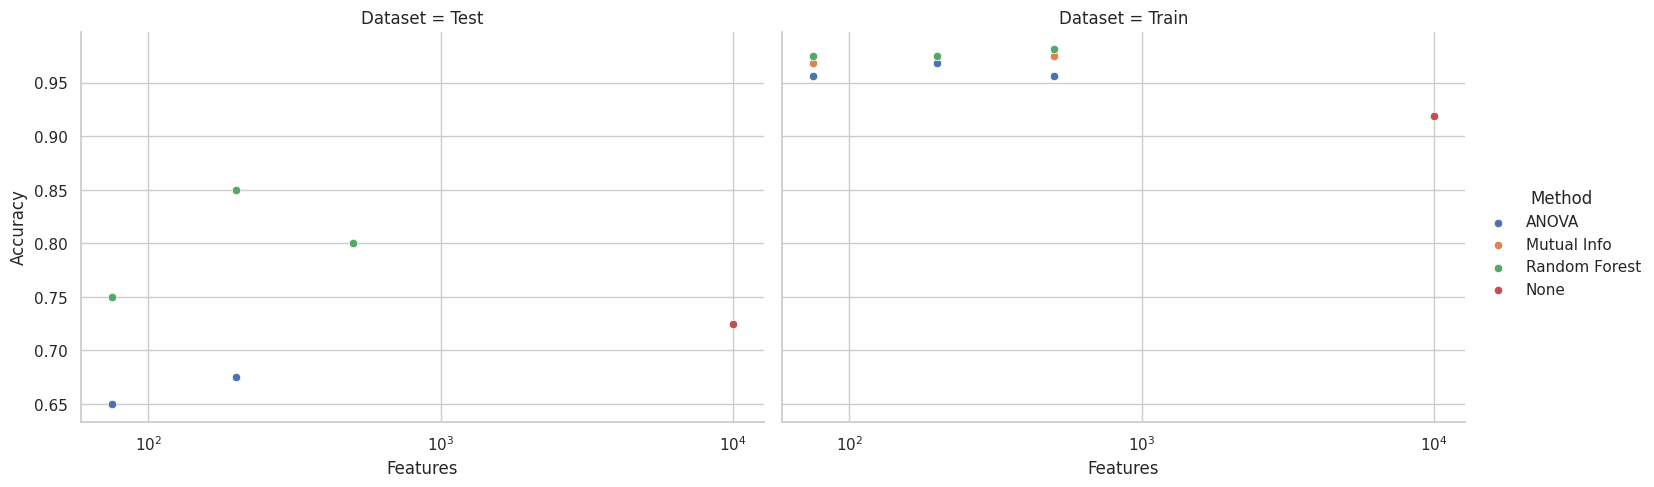

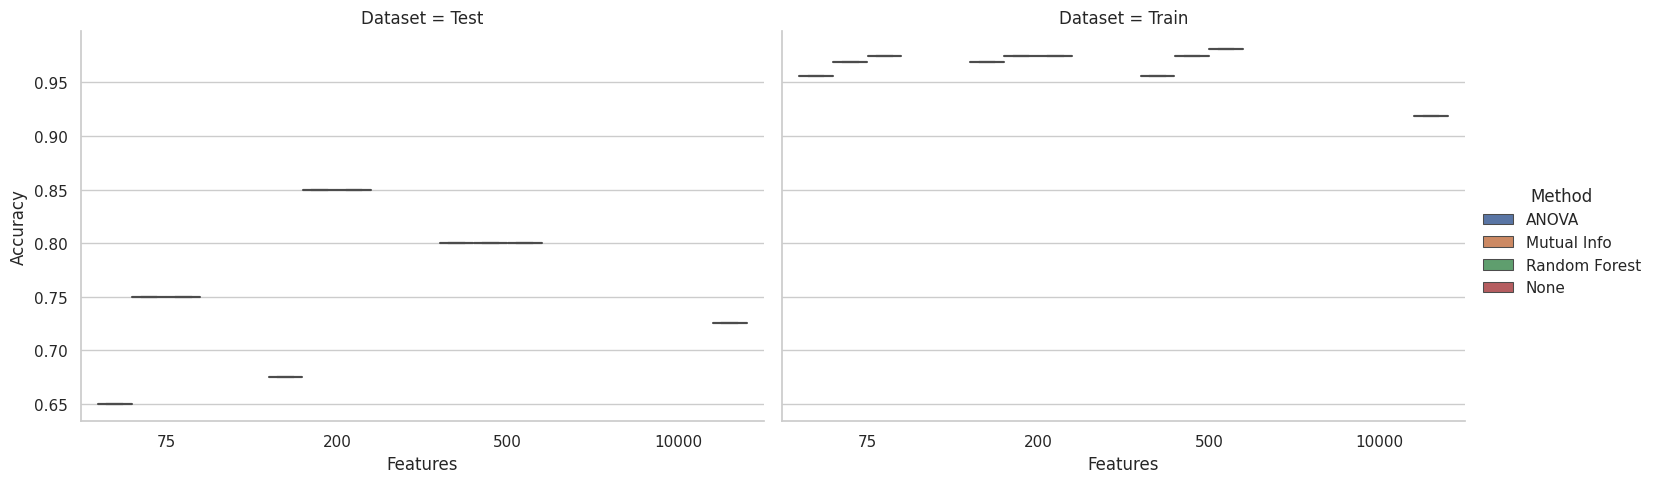

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

result_melt = results.prettify().melt(id_vars=["Features", "Method", "Seed"], value_vars=["Accuracy (test)", "Accuracy (train)"], var_name="Dataset", value_name="Accuracy")
result_melt["Dataset"] = result_melt["Dataset"].replace({"Accuracy (test)": "Test", "Accuracy (train)": "Train"})

g = sns.FacetGrid(result_melt, col="Dataset", hue="Method", height=5, aspect=1.5)
g.map(sns.scatterplot, "Features", "Accuracy")
g.add_legend()
plt.xscale('log')
plt.show()

result_simplified = result_melt.copy()
result_simplified.loc[(result_simplified["Features"] > 1000) & (result_simplified["Features"] < 1200), "Features"] = 1000
g = sns.catplot(x="Features", y="Accuracy", hue="Method", col="Dataset", data=result_simplified, kind="box", height=5, aspect=1.5)
# g.set_xticklabels(["75", "200", "500", "~1000", "3000", "10000"])
plt.show()
